#data assembly notes   
https://www.kaggle.com/c/plant-seedlings-classification/data  
#using the kaggle package to download kaggle data
kaggle competitions download -c plant-seedlings-classification 
#files are put into this dir
#/home/ec2-user/.kaggle/competitions/plant-seedlings-classification  
#unzip files to a working directory
unzip sample_submission.csv.zip  -d /home/ec2-user/kaggleData/seedlings/
unzip test.zip  -d  /home/ec2-user/kaggleData/seedlings/
unzip train.zip -d /home/ec2-user/kaggleData/seedlings/


In [1]:
import timeit
notebook_start_time = timeit.default_timer()
import os
import random
import sys 
print ("cwd:", os.getcwd()) 
print (sys.version_info)

import numpy as np
import matplotlib.pyplot as plt
import imageio

cwd: /home/ec2-user/kaggle/PlantSeedlings
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)


In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch, cv2

In [4]:
# This file contains all the main external libs we'll use
os.chdir("/home/ec2-user/fastai")
from fastai.imports import *

In [5]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [6]:
#added by AspiringGuru. 
import urllib.request 
import shutil 
import os.path

In [7]:
PATH = "data/dogscats/"
sz=224

In [8]:
print ("torch.cuda.is_available():", torch.cuda.is_available())
print ("torch.backends.cudnn.enabled:", torch.backends.cudnn.enabled)

torch.cuda.is_available(): True
torch.backends.cudnn.enabled: True


In [9]:
DATADIR = "/home/ec2-user/kaggleData/seedlings/"
TESTDIR = DATADIR + "test/"
TRAINDIR = DATADIR + "train/"
VALIDDIR = DATADIR + "valid/"
train_fraction = 0.2  #train_fraction = train/(train+test)

In [10]:
def makeDir(newDir):
    if not os.path.isdir(newDir):
        print(newDir, "did not exist, creating")
        os.makedirs(newDir)
    else:
        print(newDir, "already exists.")

In [11]:
print("DATADIR____________________________________")
print (os.listdir(DATADIR))
print("TESTDIR____________________________________")
print (len(os.listdir(TESTDIR)))
print("TRAINDIR____________________________________")
categories = os.listdir(TRAINDIR)
makeDir(VALIDDIR)
for category in categories:
    print (category, len(os.listdir(TRAINDIR+category)))
    makeDir(VALIDDIR+category)


DATADIR____________________________________
['valid', 'train', 'sample_submission.csv', 'test']
TESTDIR____________________________________
794
TRAINDIR____________________________________
/home/ec2-user/kaggleData/seedlings/valid/ already exists.
Loose Silky-bent 524
/home/ec2-user/kaggleData/seedlings/valid/Loose Silky-bent already exists.
Charlock 312
/home/ec2-user/kaggleData/seedlings/valid/Charlock already exists.
Common wheat 177
/home/ec2-user/kaggleData/seedlings/valid/Common wheat already exists.
Common Chickweed 489
/home/ec2-user/kaggleData/seedlings/valid/Common Chickweed already exists.
Shepherds Purse 185
/home/ec2-user/kaggleData/seedlings/valid/Shepherds Purse already exists.
Small-flowered Cranesbill 397
/home/ec2-user/kaggleData/seedlings/valid/Small-flowered Cranesbill already exists.
Sugar beet 308
/home/ec2-user/kaggleData/seedlings/valid/Sugar beet already exists.
Black-grass 211
/home/ec2-user/kaggleData/seedlings/valid/Black-grass already exists.
Scentless Mayw

In [12]:
print (os.getcwd())
os.chdir(DATADIR)
print (os.getcwd())
!tree -d


/home/ec2-user/fastai
/home/ec2-user/kaggleData/seedlings
.
├── test
├── train
│   ├── Black-grass
│   ├── Charlock
│   ├── Cleavers
│   ├── Common\ Chickweed
│   ├── Common\ wheat
│   ├── Fat\ Hen
│   ├── Loose\ Silky-bent
│   ├── Maize
│   ├── Scentless\ Mayweed
│   ├── Shepherds\ Purse
│   ├── Small-flowered\ Cranesbill
│   └── Sugar\ beet
└── valid
    ├── Black-grass
    ├── Charlock
    ├── Cleavers
    ├── Common\ Chickweed
    ├── Common\ wheat
    ├── Fat\ Hen
    ├── Loose\ Silky-bent
    ├── Maize
    ├── Scentless\ Mayweed
    ├── Shepherds\ Purse
    ├── Small-flowered\ Cranesbill
    └── Sugar\ beet

27 directories


In [13]:
#move fraction of files from source dir to dest dir
def moveValidfiles(fraction, sourceDir, destDir):
    sourceDir += "/"
    destDir += "/"
    print ("sourceDir:", sourceDir)
    print ("destDir:", destDir)
    #if number of files in target dir is nonzero, skip.
    targetDirList = os.listdir(destDir)
    if len(targetDirList)!=0:
        print(destDir, "already has ", len(targetDirList), "files moved in.")
        return
    fileList = os.listdir(sourceDir)
    #print (len(fileList), fileList[0:5])
    random.shuffle(fileList)
    #print (len(fileList), fileList[0:5])
    num_files_to_move = int(len(fileList)*fraction)
    print ("total files in dir:", len(fileList), ", num_files_to_move:", num_files_to_move)
    for i in range(0, num_files_to_move):
        print("i:", i, ", moving file:", sourceDir+fileList[i])
        os.rename(sourceDir+fileList[i], destDir+fileList[i])

In [14]:
for category in categories:
    moveValidfiles(train_fraction, TRAINDIR+category, VALIDDIR+category)

sourceDir: /home/ec2-user/kaggleData/seedlings/train/Loose Silky-bent/
destDir: /home/ec2-user/kaggleData/seedlings/valid/Loose Silky-bent/
/home/ec2-user/kaggleData/seedlings/valid/Loose Silky-bent/ already has  130 files moved in.
sourceDir: /home/ec2-user/kaggleData/seedlings/train/Charlock/
destDir: /home/ec2-user/kaggleData/seedlings/valid/Charlock/
/home/ec2-user/kaggleData/seedlings/valid/Charlock/ already has  78 files moved in.
sourceDir: /home/ec2-user/kaggleData/seedlings/train/Common wheat/
destDir: /home/ec2-user/kaggleData/seedlings/valid/Common wheat/
/home/ec2-user/kaggleData/seedlings/valid/Common wheat/ already has  44 files moved in.
sourceDir: /home/ec2-user/kaggleData/seedlings/train/Common Chickweed/
destDir: /home/ec2-user/kaggleData/seedlings/valid/Common Chickweed/
/home/ec2-user/kaggleData/seedlings/valid/Common Chickweed/ already has  122 files moved in.
sourceDir: /home/ec2-user/kaggleData/seedlings/train/Shepherds Purse/
destDir: /home/ec2-user/kaggleData/s

In [15]:
def tree(start_dir):
    print (start_dir)
    subdirs = os.listdir(start_dir)
    for dir_ in subdirs:
        fileList = os.listdir(start_dir+dir_)
        print (dir_, ":", len(fileList))

In [16]:
tree(VALIDDIR)
tree(TRAINDIR)

/home/ec2-user/kaggleData/seedlings/valid/
Loose Silky-bent : 130
Charlock : 78
Common wheat : 44
Common Chickweed : 122
Shepherds Purse : 46
Small-flowered Cranesbill : 99
Sugar beet : 77
Black-grass : 52
Scentless Mayweed : 103
Cleavers : 57
Fat Hen : 95
Maize : 44
/home/ec2-user/kaggleData/seedlings/train/
Loose Silky-bent : 524
Charlock : 312
Common wheat : 177
Common Chickweed : 489
Shepherds Purse : 185
Small-flowered Cranesbill : 397
Sugar beet : 308
Black-grass : 211
Scentless Mayweed : 413
Cleavers : 230
Fat Hen : 380
Maize : 177


#to reset   
cd /home/ec2-user/kaggleData/seedlings/  
rm -rf valid/  
rm -rf train/  
unzip ~/.kaggle/competitions/plant-seedlings-classification/train.zip -d ./  


In [17]:
!tree -d

.
├── test
├── train
│   ├── Black-grass
│   ├── Charlock
│   ├── Cleavers
│   ├── Common\ Chickweed
│   ├── Common\ wheat
│   ├── Fat\ Hen
│   ├── Loose\ Silky-bent
│   ├── Maize
│   ├── Scentless\ Mayweed
│   ├── Shepherds\ Purse
│   ├── Small-flowered\ Cranesbill
│   └── Sugar\ beet
└── valid
    ├── Black-grass
    ├── Charlock
    ├── Cleavers
    ├── Common\ Chickweed
    ├── Common\ wheat
    ├── Fat\ Hen
    ├── Loose\ Silky-bent
    ├── Maize
    ├── Scentless\ Mayweed
    ├── Shepherds\ Purse
    ├── Small-flowered\ Cranesbill
    └── Sugar\ beet

27 directories


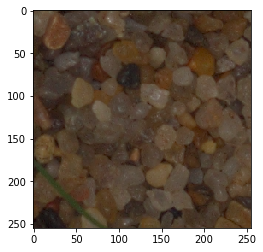

In [18]:
path = VALIDDIR+categories[0]+"/"
file = os.listdir(path)[0]
img = plt.imread(path+file)
plt.imshow(img);

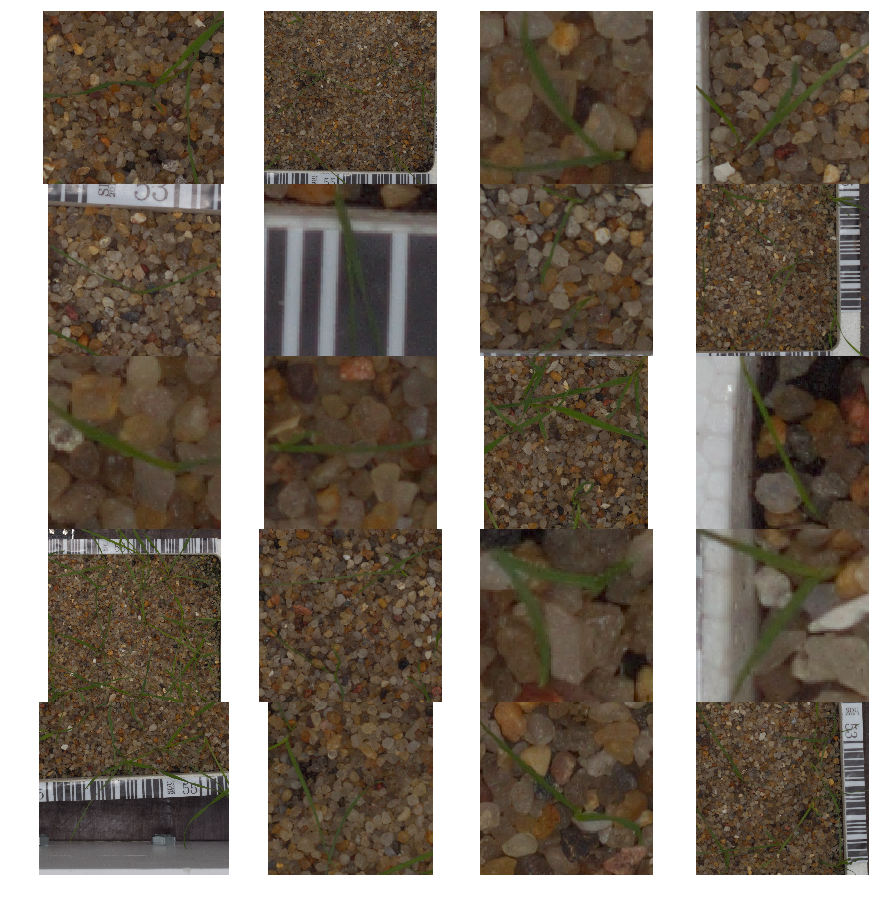

In [19]:
path = VALIDDIR+categories[0]+"/"
files = os.listdir(path)

fig=plt.figure(figsize=(12, 12))#sets overall size of fig.
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img = plt.imread(path+files[i])
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [30]:
def get_image_ratios(path):
    files = os.listdir(path)
    image_sizes = []
    for file in files:
        im = imageio.imread(path+file)
        image_sizes.append(im.shape[0]/im.shape[1])
        #print(type(im), im.shape, image_sizes)
        #break
    return image_sizes

image_ratios = get_image_ratios(VALIDDIR+categories[0]+"/")
print (len(image_ratios), max(image_ratios), min(image_ratios), image_ratios[0])

130 1.0600315955766193 0.9129353233830846 1.0


In [20]:
def get_image_sizes(path):
    files = os.listdir(path)
    image_sizes = []
    for file in files:
        im = imageio.imread(path+file)
        image_sizes.append(im.shape[0]*im.shape[1])
        #print(type(im), im.shape, image_sizes)
        #break
    return image_sizes

image_sizes = get_image_sizes(VALIDDIR+categories[0]+"/")
print (len(image_sizes))

130


In [21]:
max(image_sizes)

12624964

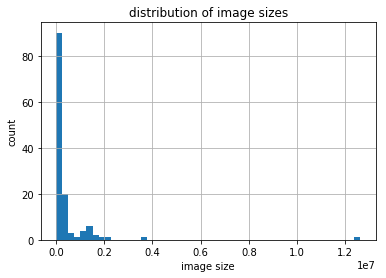

In [22]:
# the histogram of the data
n, bins, patches = plt.hist(image_sizes, 50)
plt.xlabel('image size')
plt.ylabel('count')
plt.title("distribution of image sizes")
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

In [38]:
def summarise_pixel_sizes(pixel_sizes):
    pixel_w = [400, 800, 1200, 1600]
    ans = []
    ans.append(sum(size <(pixel_w[0]*pixel_w[0]) for size in pixel_sizes))
    ans.append(sum(size <(pixel_w[1]*pixel_w[1]) for size in pixel_sizes) - ans[0])
    ans.append(sum(size <(pixel_w[2]*pixel_w[2]) for size in pixel_sizes) - ans[1])
    ans.append(sum(size <(pixel_w[3]*pixel_w[3]) for size in pixel_sizes) - ans[2])
    ans.append("smallest")
    ans.append(min(pixel_sizes))
    ans.append("largest")
    ans.append(max(pixel_sizes))
    ans.append("average")
    ans.append(sum(pixel_sizes)/len(pixel_sizes))
    return ans

In [39]:
def summarise_pixel_ratios(pixel_sizes):
    pixel_w = [0.8, 0.9, 1.0, 1.1, 1.2]
    ans = []
    ans.append(sum(size <(pixel_w[0]/pixel_w[0]) for size in pixel_sizes))
    ans.append(sum(size <(pixel_w[1]/pixel_w[1]) for size in pixel_sizes) - ans[0])
    ans.append(sum(size <(pixel_w[2]/pixel_w[2]) for size in pixel_sizes) - ans[1])
    ans.append(sum(size <(pixel_w[3]/pixel_w[3]) for size in pixel_sizes) - ans[2])
    ans.append(sum(size <(pixel_w[4]/pixel_w[4]) for size in pixel_sizes) - ans[3])
    ans.append("smallest")
    ans.append(max(pixel_sizes))
    ans.append("largest")
    ans.append(max(pixel_sizes))
    ans.append("average")
    ans.append(sum(pixel_sizes)/len(pixel_sizes))
    return ans

Charlock : [41, 23, 53, 25, 1932100]
Common wheat : [18, 20, 23, 21, 2050624]
Common Chickweed : [94, 28, 94, 28, 427716]
Shepherds Purse : [37, 7, 39, 7, 1172889]
Small-flowered Cranesbill : [58, 40, 59, 40, 719104]
Sugar beet : [23, 37, 38, 38, 2941225]
Black-grass : [22, 18, 29, 19, 6214320]
Scentless Mayweed : [76, 27, 76, 27, 591361]
Cleavers : [42, 14, 43, 14, 722500]
Fat Hen : [71, 21, 74, 21, 1263376]
Maize : [20, 11, 29, 15, 2218610]


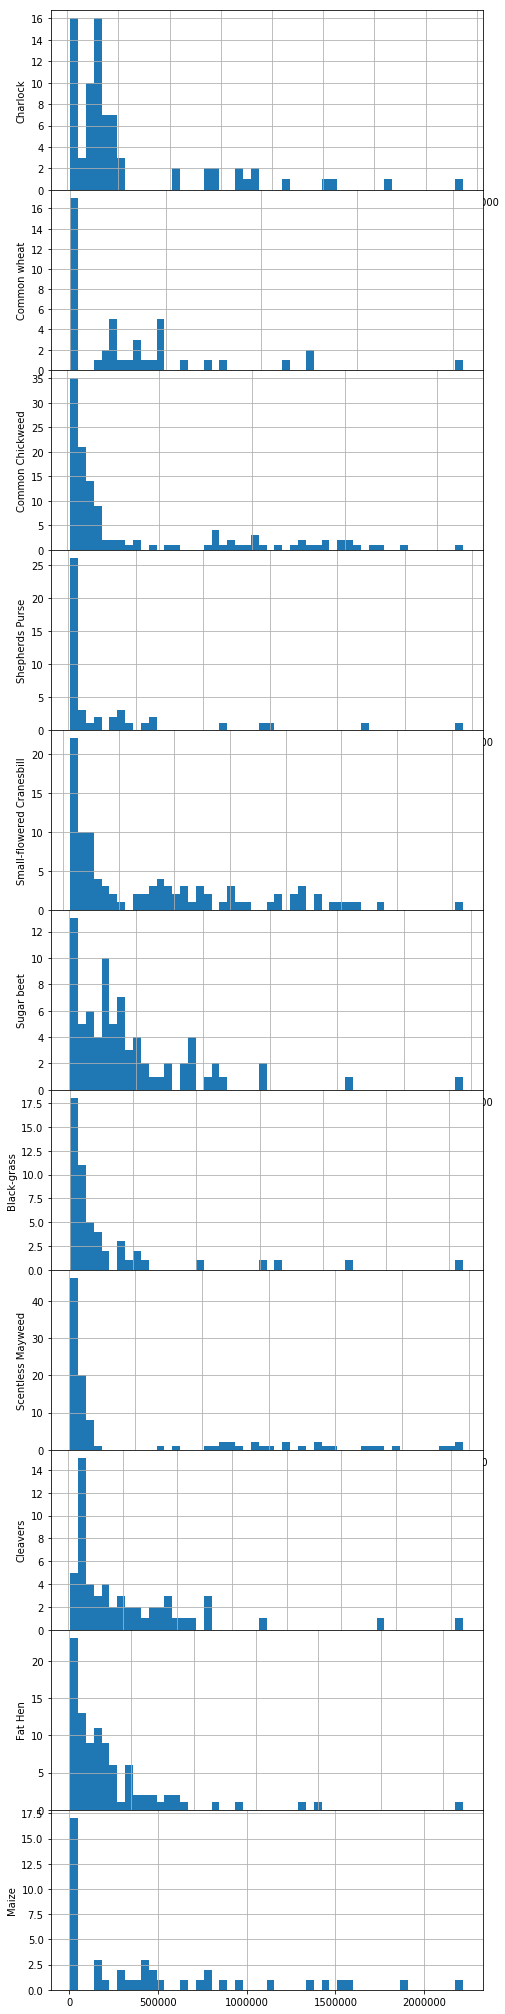

In [24]:
fig=plt.figure(figsize=(6, 30))#sets overall size of fig.
columns = 1
rows = len(categories)
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    image_sizes = get_image_sizes(VALIDDIR+categories[i]+"/")
    #
    print (categories[i], ":", summarise_pixel_sizes(image_sizes))
    plt.hist(image_sizes, 50)
    #plt.xlabel('image size')
    plt.ylabel(categories[i])
    #plt.title("distribution of image sizes")
    plt.grid(True)
    plt.subplots_adjust(wspace=1, hspace=0, left=0, right=1, bottom=1, top=2)
    #plt.axis('off')
plt.show()

Charlock : [78, 0, 78, 0, 'largest', 1.0, 'average', 1.0]
Common wheat : [44, 0, 44, 0, 'largest', 1.0, 'average', 1.0]
Common Chickweed : [122, 0, 122, 0, 'largest', 1.0, 'average', 1.0]
Shepherds Purse : [46, 0, 46, 0, 'largest', 1.0, 'average', 1.0]
Small-flowered Cranesbill : [99, 0, 99, 0, 'largest', 1.0, 'average', 1.0]
Sugar beet : [77, 0, 77, 0, 'largest', 1.0, 'average', 0.999306989701867]
Black-grass : [52, 0, 52, 0, 'largest', 1.0, 'average', 0.9933387829081498]
Scentless Mayweed : [103, 0, 103, 0, 'largest', 1.0, 'average', 1.0]
Cleavers : [57, 0, 57, 0, 'largest', 1.0, 'average', 1.0]
Fat Hen : [95, 0, 95, 0, 'largest', 1.0, 'average', 1.0]
Maize : [44, 0, 44, 0, 'largest', 1.0, 'average', 0.9999847467968274]


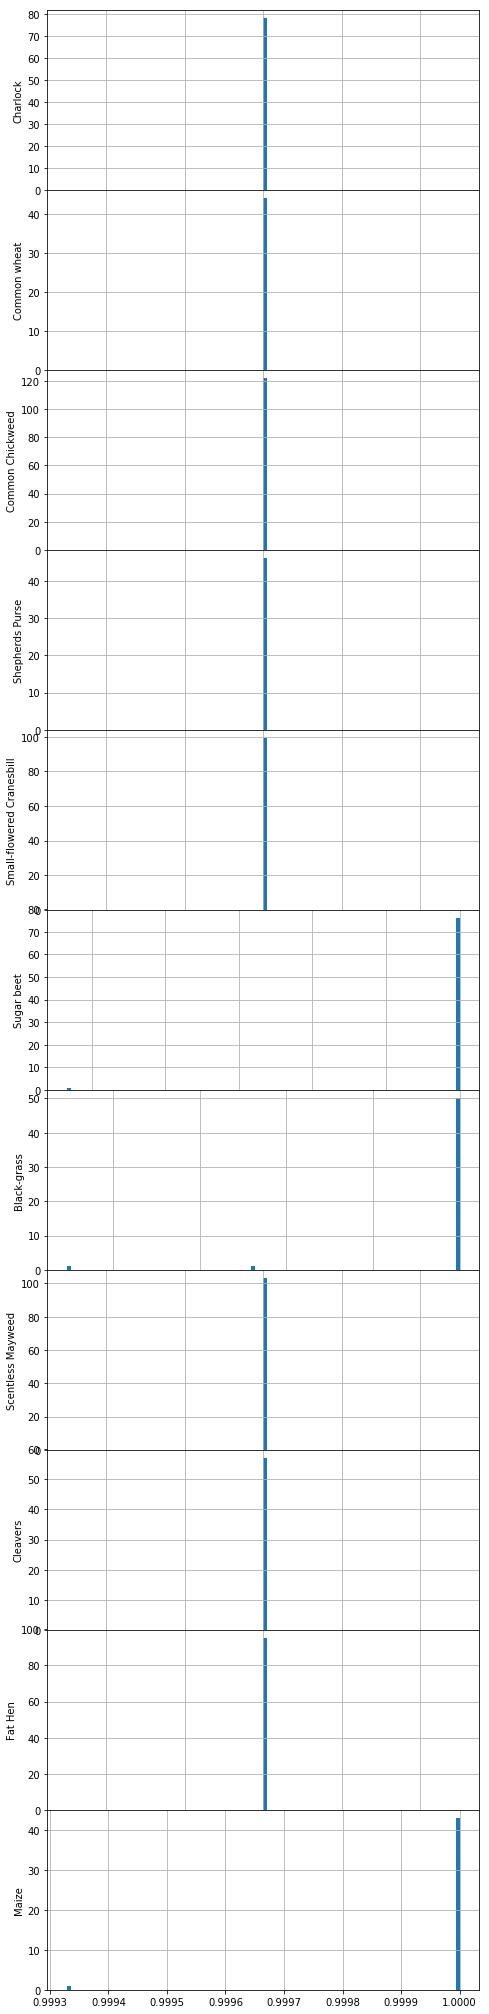

In [37]:
fig=plt.figure(figsize=(6, 30))#sets overall size of fig.
columns = 1
rows = len(categories)
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    image_ratios = get_image_ratios(VALIDDIR+categories[i]+"/")
    print (categories[i], ":", summarise_pixel_sizes(image_ratios))
    plt.hist(image_ratios, 100)
    #plt.xlabel('image size')
    plt.ylabel(categories[i])
    #plt.title("distribution of image sizes")
    plt.grid(True)
    plt.subplots_adjust(wspace=1, hspace=0, left=0, right=1, bottom=1, top=2)
    #plt.axis('off')
plt.show()

In [25]:
for pixel_w in [400, 800, 1200, 1600]:
    print (pixel_w, ":(>)", sum(size >(pixel_w*pixel_w) for size in image_sizes),
                    ":(<)", sum(size <=(pixel_w*pixel_w) for size in image_sizes) )
    


400 :(>) 24 :(<) 20
800 :(>) 13 :(<) 31
1200 :(>) 4 :(<) 40
1600 :(>) 0 :(<) 44


In [26]:
image_sizes = get_image_sizes(TESTDIR)
print ("No of images:", len(image_sizes))
for pixel_w in [400, 800, 1200, 1600]:
    print (pixel_w, ":(>)", sum(size >(pixel_w*pixel_w) for size in image_sizes),
                    ":(<)", sum(size <=(pixel_w*pixel_w) for size in image_sizes) )

    

No of images: 794
400 :(>) 0 :(<) 794
800 :(>) 0 :(<) 794
1200 :(>) 0 :(<) 794
1600 :(>) 0 :(<) 794


Summary: different distributions of image sizes exist.   
most images are under 2MB. A small number are larger, largest images are 6MB.  
image processing will have to resample files to smaller standard sizes.